## XGB EVI Trend Break Magnitude Models - v3

Peter R., 2024-02-16

### Intro
I used DRAC server (Cedar) to run a few Extreme Gradient Boosting (XGB) models with Python. I used XGBRegression() to analyze forest EVI breaks (all breaks together, only negative & only positive breaks). The response variable was EVI tren break magnitudes and the predictors were around a dozen forest and climate variables.

Here I try to answer the question: What factors predict EVI Trend Break magnitude? 

Note that driver data was assigned via spatio-temporal matches between breaks and remote sensing derived disturbance data. So far, I only have data for three drivers: fire, harvest, & insects.  The driver data are mainly nulls as I was not able to match most of the EVI breaks with disturbance data. Hence, I have left out these variables. An important missing driver is likely tree windthrow (see Somerfield et al. 2018). I also left out percent conifer as well mositure variables given the  high correlation between these and percent deciduous and precipitation.

Here I manily explore and create visualizations of the models created with DRAC. The new models (v3 & v4) have the new set of ClimateNA variables (e.g., number of frost free days).

#### Positive breaks XGB model

Here I run positive breaks only.

In [4]:
import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Get the current working directory
cwd = os.getcwd()

print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")


# Load model
# load saved model
#model_bp1 = xgb.XGBRegressor()
#model_bp1.load_model("model_bp2_pos_brks_v4.json")


C:\Users\Peter R\github\forc_trends\models\xgboost


In [46]:
# Windows
df1 = pd.read_csv(r'.\data\forest_evi_breaks_positive_v2.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v1.csv', skipinitialspace=True)
#df1.head()

df2 = pd.get_dummies(df1, columns=['for_pro'], dtype=float)

#df2= df2[df2['precipitation'].notna()]

#X1 = df2.iloc[:,2:30]

#X1.drop(X1.columns[[2, 12, 14, 16, 18, 19, 20,21,22,23,24,25]], axis=1,inplace=True)

#cols2 = ['for_age','for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt', 'nffd_wt', 'nffd_wt_lag1', 'nffd_wt_lag2', 'nffd_wt_lag3', 'pas_sm', 'pas_sm_lag1', 'pas_sm_lag2', 'pas_sm_lag3', 'for_pro_0']
cols2 = ['for_age','for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt', 'nffd_wt', 'nffd_wt_lag1', 'nffd_wt_lag2', 'nffd_wt_lag3', 'pas_sm', 'pas_sm_lag1', 'pas_sm_lag2', 'pas_sm_lag3', 'for_pro_0', 'map', 'map_lag1', 'map_lag2', 'map_lag3','mat', 'mat_lag1', 'mat_lag2', 'mat_lag3','rh', 'rh_lag1', 'rh_lag2', 'rh_lag3']
#cols2 =  ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt', 'dd5_wt_lag2']
#cols2 = ['for_age','for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt', 'dd5_wt_lag2', 'for_pro_0', 'for_pro_1']

X1 = df2[cols2]

#y1 = df2.iloc[:,1]
y1 = df2.iloc[:,6]


#features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
 #                "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

seed = 7 # random seed to help with replication
testsize1 = 0.33 # percent of records to test after training

# Split data set. Note the 'stratify' option
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed)

#print(df2.describe)

In [47]:
print(X1.describe)
#cols2

<bound method NDFrame.describe of          for_age  for_con  cmi_sm  cmi_sm_lag1  cmi_sm_lag2  cmi_sm_lag3  \
0      90.652313   60.374  -5.753        3.632       -2.837      -11.127   
1     103.445618   25.777  -4.637       10.508       -0.854       -4.958   
2      81.650734   53.178  -4.739        9.859       -1.417       -5.528   
3     110.992073   11.073  -3.405       11.312       -1.189       -4.410   
4      85.456337   32.724  -5.511        0.523       -3.657      -14.041   
...          ...      ...     ...          ...          ...          ...   
3930   96.809013    2.917   5.843        6.397       -0.149        1.227   
3931   78.635590   19.991  14.432        0.723       -1.454       -5.521   
3932   74.284645    0.000     NaN          NaN        4.129        7.226   
3933   86.193192    8.311   7.803       -0.564        2.738       11.140   
3934   85.861099   19.864     NaN          NaN        5.312        4.162   

      dd5_wt  nffd_wt  nffd_wt_lag1  nffd_wt_lag2  ..

In [48]:
#print(X1.describe)
# Count NAs per columns to check that step above worked
X1.isna().sum()

for_age          83
for_con          84
cmi_sm          607
cmi_sm_lag1     535
cmi_sm_lag2      42
cmi_sm_lag3       0
dd5_wt          607
nffd_wt         607
nffd_wt_lag1    535
nffd_wt_lag2     42
nffd_wt_lag3      0
pas_sm          607
pas_sm_lag1     535
pas_sm_lag2      42
pas_sm_lag3       0
for_pro_0         0
map             607
map_lag1        535
map_lag2         42
map_lag3          0
mat             607
mat_lag1        535
mat_lag2         42
mat_lag3          0
rh              607
rh_lag1         535
rh_lag2          42
rh_lag3           0
dtype: int64

In [3]:
#EVALUATION (with train and CV)

# pos bp1
#Mean MAE: 220.499 (13.534)
#Mean MSE: 220.499 (13.534)
#Mean RMSE: 14.849 (3.679)
#Mean Var. Explained: 0.310 (0.070)
#R-sq: 0.305 (0.070)
#MSE: 105226.33
#RMSE: 324.39
#R-sq: 0.33
#Total time: 3756.35


# EVALUATION (with test)
#eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
#model_bp1.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
# make predictions for test data
#y_pred = model_bp1.predict(x1_test)
#predictions = [round(value) for value in y_pred]
# retrieve performance metrics
#results = model_bp1.evals_result()

#mse = mean_squared_error(y1_test, y_pred)
#r2 = explained_variance_score(y1_test, ypred)
#r2 = r2_score(y1_test, y_pred)
#print("MSE: %.2f" % mse)

#print("RMSE: %.2f" % (mse**(1/2.0)))

#print("R-sq: %.2f" % r2)

In [49]:
# Best parameters 2nd model

# Load model
# load saved model
model_bp2 = xgb.XGBRegressor()
model_bp2.load_model("model_bp2_pos_brks_v4.json")
#model_bp2.load_model("model_bp2_pos_brks_v5.json")
#model_bp2.load_model("model_bp2_pos_brks_v6.json")
#model_bp2
#model_bp2.best_score
#model_bp2.best_iteration (this is not number of trees)



In [50]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# EVALUATION (with test)
eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model_bp2.predict(x1_test)
predictions = [round(value) for value in y_pred]
# retrieve performance metrics
results = model_bp2.evals_result()

#epochs = len(results['validation_0']['error'])
#x_axis = range(0, epochs)


mse = mean_squared_error(y1_test, y_pred)
#r2 = explained_variance_score(y1_test, ypred)
r2 = r2_score(y1_test, y_pred)

# adjusted R-squared
adj_r2 =1 - (1-r2) * (len(y1_test)-1)/(len(y1_test)-x1_test.shape[1]-1)

print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

print("R-sq: %.3f" % r2)

print("adj-R-sq: %.3f" % adj_r2)

#model_bp1
#MSE: 108697.93
#RMSE: 329.69
#R-sq: 0.31

#MSE: 102081.95
#RMSE: 319.50
#R-sq: 0.355

# VIF Subset of new vars
#MSE: 119265.23
#RMSE: 345.35
#R-sq: 0.315

# Model v4
#MSE: 103448.16
#RMSE: 321.63
#R-sq: 0.298
#adj-R-sq: 0.283




MSE: 103448.16
RMSE: 321.63
R-sq: 0.298
adj-R-sq: 0.283


**Table 1**: Model comparison for positive breaks.

| Month    | Model v3| Model v4 | Model v5 | Model v6 |
| -------- | ------- |-------- | ------- |-------- | 
| MSE|  119265.23  |103448.16|
| RMSE| 345.35   |321.63|
| R-sq| 0.315  |0.298|
| R-sq Adj.| - |0.283|

In [1]:
# plot log loss
#fig, ax = pyplot.subplots()
#ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
#ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
#pyplot.axvline(2341, color="gray", label="Optimal tree number")
#pyplot.xlabel("Number of trees")
#pyplot.ylabel("Loss")
#pyplot.legend()
#pyplot.show()
# This plot tells me I should run another model limiting the number of trees

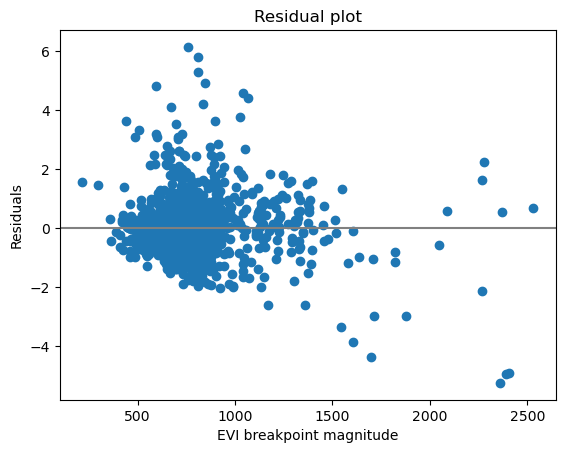

In [51]:
# Model prediction residuals

residuals = y1_test-y_pred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(y_pred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI breakpoint magnitude")
pyplot.title('Residual plot')
pyplot.axhline(0, color="gray")

pyplot.show()

In [8]:
# Feature importance plot
#xgb.plot_importance(model_bp1, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, weight', 
#                    xlabel='F score - weight', ylabel='Features', 
#                    importance_type='weight', max_num_features=10, grid=True, show_values=True)

#plt.savefig('weight.png',  dpi=300, bbox_inches='tight')

#pyplot.show()

#‘weight’: the number of times a feature is used to split the data across all trees.
# weight: is the percentage representing the relative number of times a particular feature occurs in the trees of the model
# less indicative of the predictive contribution of a feature for the whole model.
# binary feature score low with weight but high with gain and coverage

#‘gain’: the average gain across all splits the feature is used in.
# gain: Gain' is the improvement in accuracy brought by a feature to the branches it is on. Higher value the more important
# The Gain is the most relevant attribute to interpret the relative importance of each feature.
# ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. 

#‘cover’: the average coverage across all splits the feature is used in.
# cover: The Coverage metric means the relative number of observations related to this feature. Observation-level scope

#‘total_gain’: the total gain across all splits the feature is used in.

#‘total_cover’: the total coverage across all splits the feature is used in.

# F score: This is a metric that simply sums up how many times each feature is split on

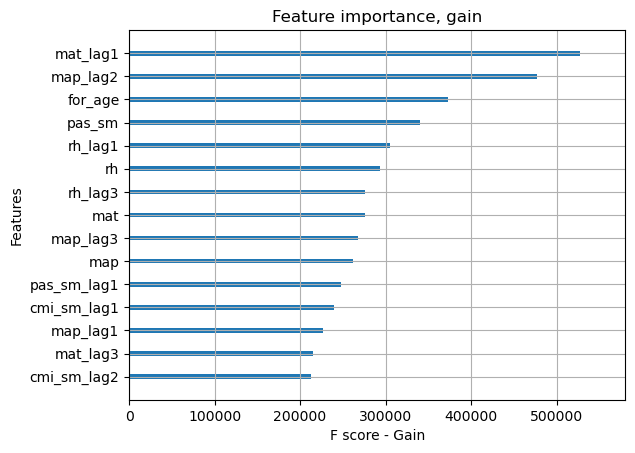

In [54]:
# Plot, metric: gain
#‘gain’: the average gain across all splits the feature is used in.
xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )

pyplot.savefig(r'.\figs\version2\pos_gain1_mv4_v1.png',  dpi=300, bbox_inches='tight')

pyplot.show()

In [10]:
# Plot, metric: total gain
#‘total_gain’: the total gain across all splits the feature is used in.
#xgb.plot_importance(model_bp1, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, Total gain', 
#                    xlabel='F score - Total gain', ylabel='Features', 
#                    importance_type='total_gain', max_num_features=10, grid=True, show_values=False)

#pyplot.savefig('total_gain6.png',  dpi=300, bbox_inches='tight')

#pyplot.show()

In [43]:
#import matplotlib.pyplot as plt

#x_ax = range(len(y1_test))
#pyplot.plot(x_ax, y1_test, label="original")
#pyplot.plot(x_ax, y_pred, label="predicted")

#pyplot.xlabel("Record number") # Order of observations/records in vector

#pyplot.title("EVI Trend Breaks Magnitude")

#pyplot.legend()

#plt.savefig('original_vs_predicted6.png',  dpi=300, bbox_inches='tight')


#pyplot.savefig(r'.\figs\version2\pos_predicted6.png',  dpi=300, bbox_inches='tight')

#pyplot.show()

In [44]:
# Plot tree. Use rankdir='LR' to make the plot show sideways
#import graphviz

#fig, ax = pyplot.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))

#xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) #num_trees = model_m2e.best_iteration

#format = 'png' #You should try the 'svg'

#image = xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) # best_iteration only works with early_stop_rounds

#image

#Set a different dpi (works only if format == 'png')
#image.graph_attr = {'dpi':'300'}

#image.render(r'.\figs\pos_decision_tree6.png', format = format)

#image

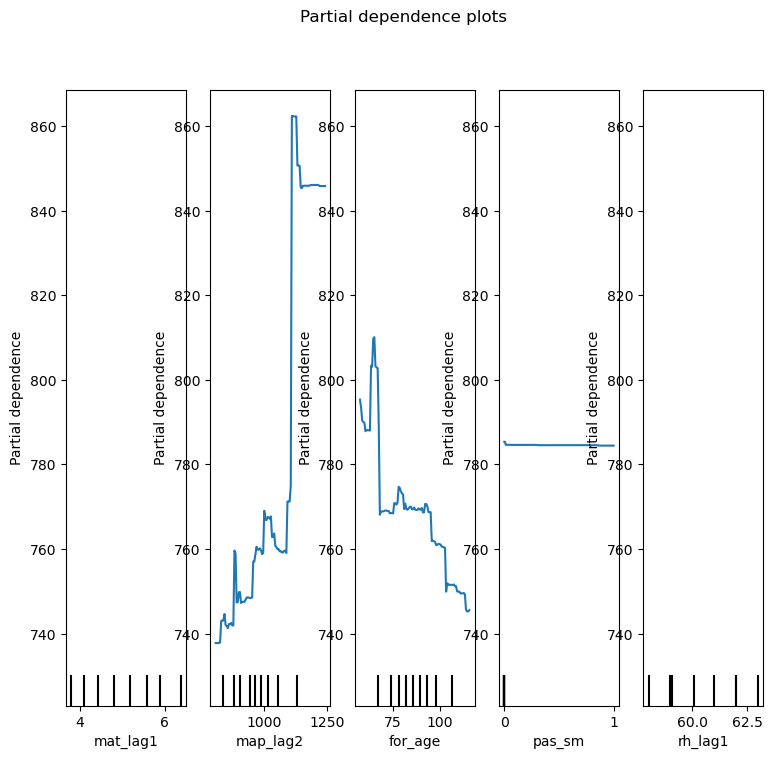

In [58]:
# Partial dependence plots

import matplotlib.pyplot as plt

# PDP is an average of the marginal effects of the features. We are averaging the response of all samples of the provided set.
from sklearn.inspection import PartialDependenceDisplay

#["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
#                 "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

#features_names2 = ["temperature_lag2", "precipitation_lag1", "rh", "precipitation_lag2", "temperature_lag3", "precipitation_lag3", "protected_0", "rh_lag1", "rh_lag2", "age"]
#target_names1 = "Magnitude"
#features_names2 = ['map_lag2', 'map_lag1', 'rh_lag1', 'map_lag2', 'rh', 'rh_lag2', 'nffd_wt_lag3', 'pas_sm', 'cmi_sm_lag1', 'mat', 'pas_sm_lag1', 'map', 'map_lag3', 'dd5_wt', 'pas_sm_lag2']

# Top 5. Some curves are not shown
features_names2 = ['mat_lag1', 'map_lag2', 'for_age', 'pas_sm', 'rh_lag1']


_, ax1 = plt.subplots(ncols=5, nrows=1, figsize=(9, 8), constrained_layout=False)

display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2 , ax=ax1)


_ = display.figure_.suptitle(
    (
        "Partial dependence plots"
        
    ),
    fontsize=12,
)

#plt.savefig(r'.\figs\version2\pos_partial_dependence2.png',  dpi=300, bbox_inches='tight')

plt.show()

# Black ticks on X-axis are deciles

#### Negative breaks XGB model

Here I run a model with negative breaks only

In [70]:
import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Get the current working directory
cwd = os.getcwd()

print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")


# Load model
# load saved model
model_bp1 = xgb.XGBRegressor()
model_bp1.load_model("model_bp2_neg_brks_v4.json")

C:\Users\Peter R\github\forc_trends\models\xgboost


In [37]:
# Windows
df1 = pd.read_csv(r'.\data\forest_evi_breaks_negative_v2.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v1.csv', skipinitialspace=True)
#df1.head()

df2 = pd.get_dummies(df1, columns=['for_pro'], dtype=float)

#df2= df2[df2['precipitation'].notna()]

#X1 = df2.iloc[:,2:30]

#X1.drop(X1.columns[[2, 12, 14, 16, 18, 19, 20,21,22,23,24,25]], axis=1,inplace=True)

#y1 = df2.iloc[:,1]

#cols2 = ['for_age','for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt', 'nffd_wt', 'nffd_wt_lag1', 'nffd_wt_lag2', 'nffd_wt_lag3', 'pas_sm', 'pas_sm_lag1', 'pas_sm_lag2', 'pas_sm_lag3', 'for_pro_0']
cols2 = ['for_age','for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt', 'nffd_wt', 'nffd_wt_lag1', 'nffd_wt_lag2', 'nffd_wt_lag3', 'pas_sm', 'pas_sm_lag1', 'pas_sm_lag2', 'pas_sm_lag3', 'for_pro_0', 'map', 'map_lag1', 'map_lag2', 'map_lag3','mat', 'mat_lag1', 'mat_lag2', 'mat_lag3','rh', 'rh_lag1', 'rh_lag2', 'rh_lag3']

X1 = df2[cols2]

#y1 = df2.iloc[:,1]
y1 = df2.iloc[:,6].abs()


#features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
#                 "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

seed = 7 # random seed to help with replication
testsize1 = 0.33 # percent of records to test after training

# Split data set. Note the 'stratify' option
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed)

In [38]:
#EVALUATION (with train and CV)
#neg
#Mean MAE: 202.595 (6.349)
#Mean MSE: 202.595 (6.349)
#Mean Var. Explained: 0.360 (0.057)
#R-sq: 0.359 (0.057)
#MSE: 82562.94
#RMSE: 287.34
#R-sq: 0.36
#Total time: 4665.40
print(X1.describe)

<bound method NDFrame.describe of           for_age  for_con  cmi_sm  cmi_sm_lag1  cmi_sm_lag2  cmi_sm_lag3  \
0       97.534363   39.790  -5.512       11.532       -0.775       -4.094   
1      103.805267   25.988  -5.397       11.579       -0.706       -4.067   
2      121.467087   15.982  -2.151        3.244       -2.090      -13.590   
3       96.266518   18.568  -3.623       12.446       -0.835       -3.538   
4       70.226051   69.988  -6.601        3.780       -2.150      -10.606   
...           ...      ...     ...          ...          ...          ...   
11964   75.797562   47.156  -7.664       -4.626        2.243       -2.879   
11965   78.351295   71.706     NaN        0.993        5.520       -4.309   
11966   88.692871   16.657  -1.028        7.885       -1.316       -7.095   
11967   86.798828   22.068   1.148        5.510       -0.953      -10.605   
11968   93.373856   17.931  -1.751        7.892       -3.701       -7.327   

       dd5_wt  nffd_wt  nffd_wt_lag1  nff

In [39]:
# Count NAs per columns to check that step above worked
X1.isna().sum()

for_age         208
for_con         216
cmi_sm          448
cmi_sm_lag1     208
cmi_sm_lag2      98
cmi_sm_lag3       0
dd5_wt          448
nffd_wt         448
nffd_wt_lag1    208
nffd_wt_lag2     98
nffd_wt_lag3      0
pas_sm          448
pas_sm_lag1     208
pas_sm_lag2      98
pas_sm_lag3       0
for_pro_0         0
map             448
map_lag1        208
map_lag2         98
map_lag3          0
mat             448
mat_lag1        208
mat_lag2         98
mat_lag3          0
rh              448
rh_lag1         208
rh_lag2          98
rh_lag3           0
dtype: int64

In [28]:
# Count NAs per columns to check that step above worked
y1.isna().sum()

0

In [40]:
# Best parameters 2nd model

# Load model
# load saved model
model_bp2 = xgb.XGBRegressor()
model_bp2.load_model("model_bp2_neg_brks_v4.json")
#model_bp2
#model_bp2.best_score
model_bp2.best_iteration #(this is not number of trees)

644

In [41]:
from matplotlib import pyplot

# EVALUATION (with test)
eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model_bp2.predict(x1_test)
predictions = [round(value) for value in y_pred]
# retrieve performance metrics
results = model_bp2.evals_result()

#epochs = len(results['validation_0']['error'])
#x_axis = range(0, epochs)


mse = mean_squared_error(y1_test, y_pred)
#r2 = explained_variance_score(y1_test, ypred)
r2 = r2_score(y1_test, y_pred)

# adjusted R-squared
adj_r2 =1 - (1-r2) * (len(y1_test)-1)/(len(y1_test)-x1_test.shape[1]-1)

print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

print("R-sq: %.3f" % r2)

print("adj-R-sq: %.3f" % adj_r2)


#MSE: 82239.75
#RMSE: 286.77
#R-sq: 0.36

#MSE: 82860.38
#RMSE: 287.85
#R-sq: 0.353

#MSE: 81097.54
#RMSE: 284.78
#R-sq: 0.341

# Model v3
#MSE: 77879.69
#RMSE: 279.07
#R-sq: 0.367

# Model v4
#MSE: 80490.14
#RMSE: 283.71
#R-sq: 0.395
#adj-R-sq: 0.390



MSE: 80490.14
RMSE: 283.71
R-sq: 0.395
adj-R-sq: 0.390


**Table 2**: Model comparison for negative breaks.

| Month    | Model v3| Model v4 | Model v5 | Model v6 |
| -------- | ------- |-------- | ------- |-------- | 
| MSE|  77879.69   |80490.14|
| RMSE| 279.07    |283.71|
| R-sq| 0.367   |0.395|
| R-sq Adj.| - |0.390|


In [16]:
# plot log loss
#fig, ax = pyplot.subplots()
#ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
#ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
#pyplot.axvline(100, color="gray", label="Optimal tree number")
#pyplot.xlabel("Number of trees")
#pyplot.ylabel("Loss")
#pyplot.legend()
#pyplot.show()
# This plot tells me I should run another model limiting the number of trees

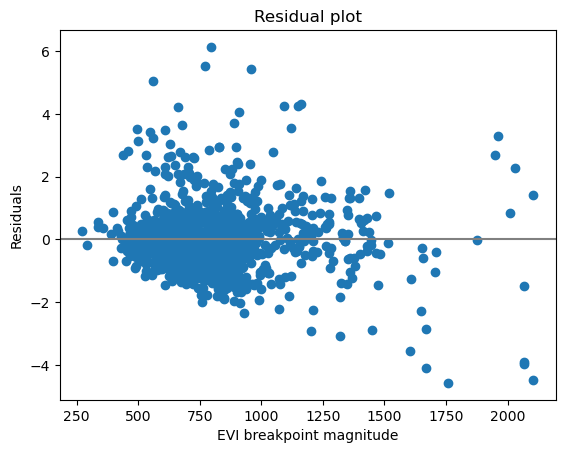

In [24]:
# Model prediction residuals

residuals = y1_test-y_pred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(y_pred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI breakpoint magnitude")
pyplot.title('Residual plot')
pyplot.axhline(0, color="gray")

pyplot.show()

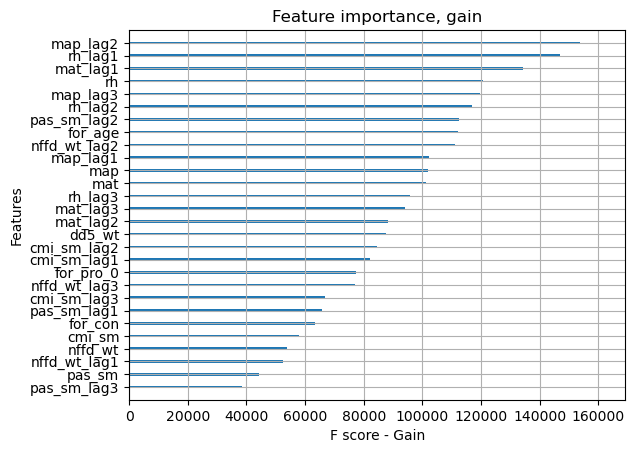

In [26]:
# Plot, metric: gain
#‘gain’: the average gain across all splits the feature is used in.
xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=30, grid=True, show_values=False) #, values_format='{v:.2f}' )

pyplot.savefig(r'.\figs\version2\neg_gain1_m4_v1.png',  dpi=300, bbox_inches='tight')


pyplot.show()

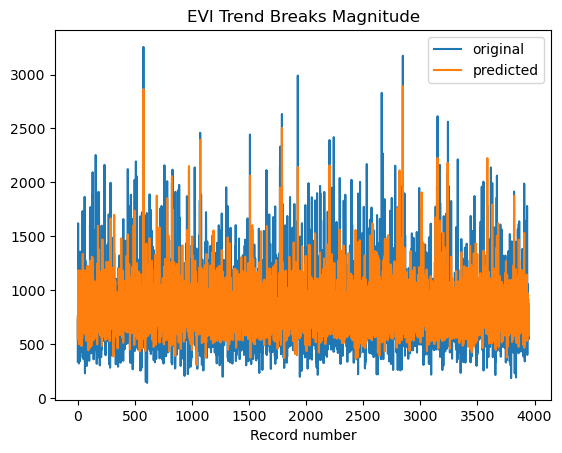

In [57]:
#import matplotlib.pyplot as plt

x_ax = range(len(y1_test))
pyplot.plot(x_ax, y1_test, label="original")
pyplot.plot(x_ax, y_pred, label="predicted")

pyplot.xlabel("Record number") # Order of observations/records in vector

pyplot.title("EVI Trend Breaks Magnitude")

pyplot.legend()

pyplot.savefig(r'.\figs\version2\neg_predicted2.png',  dpi=300, bbox_inches='tight')

pyplot.show()

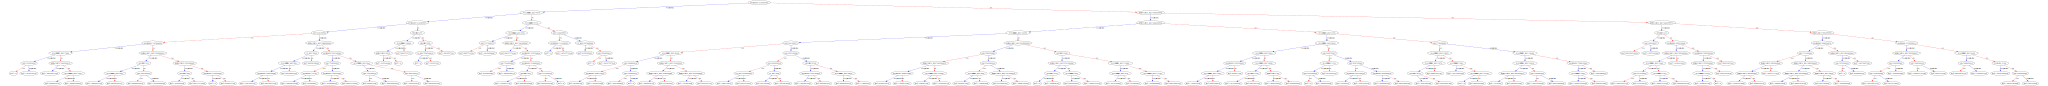

In [26]:
# Plot tree. Use rankdir='LR' to make the plot show sideways
import graphviz

#fig, ax = pyplot.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))

#xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) #num_trees = model_m2e.best_iteration

format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) # best_iteration only works with early_stop_rounds

#image

#Set a different dpi (works only if format == 'png')
image.graph_attr = {'dpi':'300'}

#image.render(r'.\figs\neg_decision_tree6.png', format = format)

image

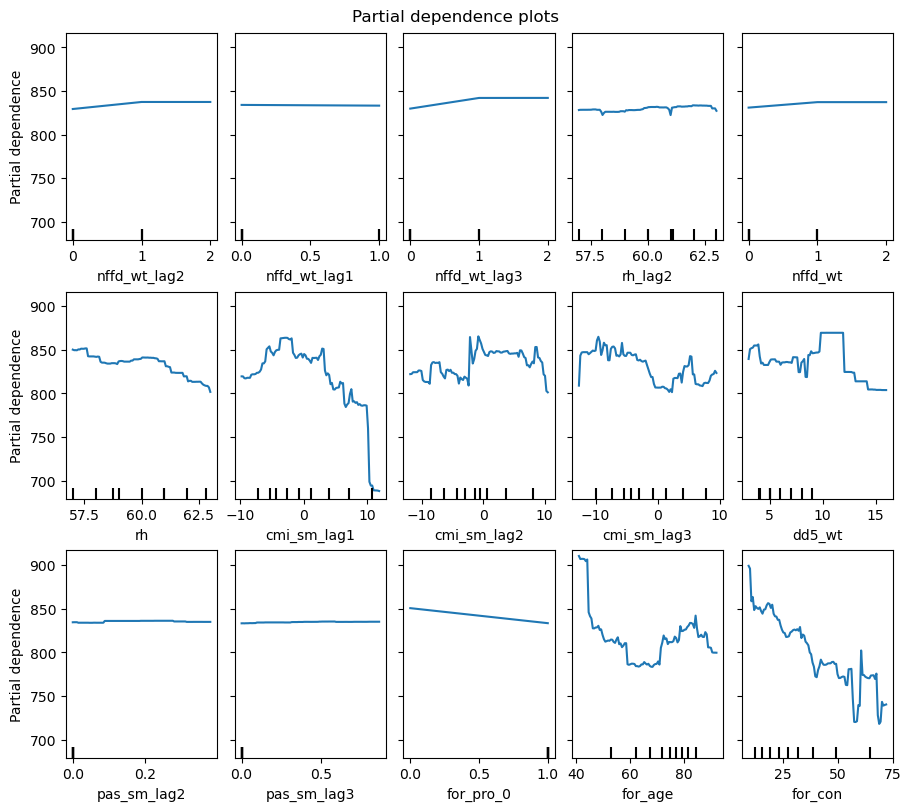

In [61]:
# Partial dependence plots

import matplotlib.pyplot as plt

# PDP is an average of the marginal effects of the features. We are averaging the response of all samples of the provided set.
from sklearn.inspection import PartialDependenceDisplay

#["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
#                 "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

#features_names2 = ["rh", "rh_lag2", "temperature_lag3",  "rh_lag1", "precipitation_lag3", "precipitation_lag2", "temperature_lag2", "temperature", "precipitation_lag1", "precipitation"]
#target_names1 = "Magnitude"
#features_names2 = ['nffd_wt', 'pas_sm', 'pas_sm_lag3', 'cmi_sm_lag3', 'cmi_sm_lag2', 'nffd_wt_lag2', 'nffd_wt_lag3', 'cmi_sm_lag1', 'dd5_wt', 'pas_sm_lag1','nffd_wt_lag1','for_pro_0','cmi_sm', 'for_con', 'for_age' ]
# new + old vars
features_names2 = ['nffd_wt_lag2', 'nffd_wt_lag1', 'nffd_wt_lag3', 'rh_lag2', 'nffd_wt', 'rh', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt',  'pas_sm_lag2', 'pas_sm_lag3', 'for_pro_0', 'for_age','for_con']


_, ax1 = plt.subplots(ncols=5, nrows=3, figsize=(9, 8), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

_ = display.figure_.suptitle(
    (
        "Partial dependence plots"
        
    ),
    fontsize=12,
)


plt.savefig(r'.\figs\version2\neg_partial_dependence2.png',  dpi=300, bbox_inches='tight')

plt.show()

# Black ticks on X-axis are deciles

#### All breaks (negative & positive) XGB model -- SKip

C:\Users\Peter R\anaconda3\envs\xgboost1\lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


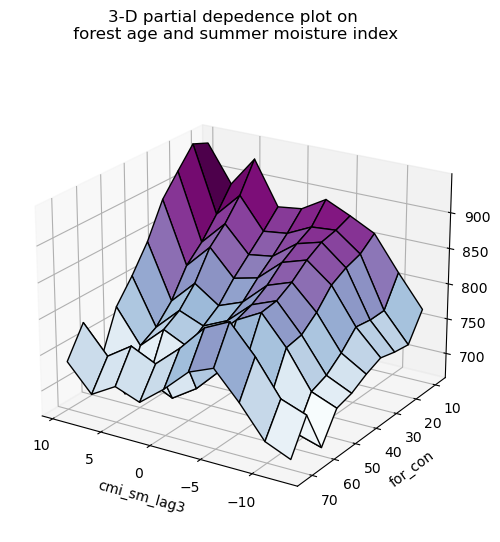

In [42]:
# 3D plot
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np

from sklearn.inspection import partial_dependence

fig = plt.figure(figsize=(6.5,6))

features = ("cmi_sm_lag3", "for_con")

pdp = partial_dependence(
    model_bp2,
    x1_train, features=features, kind="average", grid_resolution=10
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1]) #"grid_values" in newer version of sklearn
Z = pdp.average[0].T
ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
fig.suptitle(
    "3-D partial depedence plot on\n forest age and summer moisture index",
    fontsize=12,
)
# pretty init view
ax.view_init(elev=22, azim=122)
#clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
#clb.ax.set_title("Partial\ndependence")

plt.savefig(r'.\figs\version2\neg_3d_partial_dependence1.png',  dpi=300, bbox_inches='tight')

plt.show()

#### References

Mostly tutorials & blogs.

https://www.youtube.com/watch?v=OQKQHNCVf5k

https://www.youtube.com/watch?v=GrJP9FLV3FE&t=2167s

https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost

https://mljar.com/blog/xgboost-save-load-python/

https://machinelearningmastery.com/xgboost-for-regression/

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

https://github.com/parrt/dtreeviz

https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

https://scikit-learn.org/stable/modules/partial_dependence.html

https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#way-partial-dependence-with-different-models

https://mljar.com/blog/xgboost-early-stopping/

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

https://github.com/parrt/dtreeviz

https://stackoverflow.com/questions/49381661/how-do-i-calculate-the-adjusted-r-squared-score-using-scikit-learn


